In [1]:
# %matplotlib inline

# Importing Libraries

In [10]:
import tensorflow as tf
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
from collections import Counter
import copy
# import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math
import json
import os
import time
from datetime import datetime
import datetime as dtm
import pickle
import csv
# from keras.models import Model, load_model
# For EC2
# import boto3
import keras



ImportError: No module named 'keras'

# Helpful Functions

In [42]:
def generate_random_mini_batch(batch_size):
    mini_batch = np.zeros((batch_size, NUM_INPUT_CHANNELS, X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS))
    for batch_index in range(batch_size):
        # Randomly sample the image
        day_index = np.random.randint(NUM_DAYS)
        sample_date = FIRST_DATE + dtm.timedelta(days=day_index)
        time_slot = np.random.randint(NUM_TIME_SLOTS)
        location_x = np.random.randint(X_MAX_PIXELS-2*X_WINDOW_MAX_PIXELS)+X_WINDOW_MAX_PIXELS
        location_y = np.random.randint(Y_MAX_PIXELS-2*Y_WINDOW_MAX_PIXELS)+Y_WINDOW_MAX_PIXELS
        mini_batch[batch_index] = get_network_input_location(day_index,
                                                             sample_date.day,
                                                             sample_date.month,
                                                             sample_date.year,
                                                             time_slot,
                                                             location_x,
                                                             location_y)
        return mini_batch

    
#testing data generation capabilities
# start = time.time()
# generate_random_mini_batch(100)
# end = time.time()
# print(end-start)
    
    
# Utility Functions #

####################
# EPOCH MANAGEMENT #
####################

def extract_data_for_date(record, fast_lookup, column):
    record_date = datetime(record.Date.year, record.Date.month, record.Date.day)
    index = (record_date - FIRST_DATE).days
    if index < NUM_DAYS and index >= 0:
        fast_lookup[index] = record[column]
    
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    Reference: https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
fast_lookup
    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]    



In [43]:
# dataPath = r'C:/Users/User/Desktop/newMe/newMe/Training/Stanford/Deep Learning Class/Project/python_code/datafile/'
def pObj_old(obj, fileName):
    path = fileName
    pickle.dump( obj, open( path, "wb" ) )

def rObj_old(fileName):
    path = fileName
    return pickle.load( open( path, "rb" ) )


def pObj(df, fileName):
    path = fileName
    df.to_csv(path, sep=',', index=False)

def rObj(fileName):
    path = fileName
    return pd.read_csv(path, sep=',') 

def cleanURL(url):
    p = pathlib.Path(url)
    path = str(p.as_posix()) 
    return path 


def getDF(loc, sheetname):
    dataframe = pd.read_excel(loc, sheetname)
    #https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
    dataframe = dataframe.applymap(lambda x: x.strip() if type(x) is str else x)
    return dataframe

def printNulls(df):
    null_columns = df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum() 


def writeDFToFile(dfs, path_): #dfs is an array of dataframes and their sheet names , path needs to have
    time_ = str(datetime.now())
    current_date_time = time_[0:time_.index(".")]
    current_date_time = current_date_time.replace(":", "-")
    task4_fileoutput = path_+current_date_time+".xlsx"

    writer = pd.ExcelWriter(task4_fileoutput)
    
    for df_tuple in dfs:  
        df = df_tuple[0]
        sheetName = df_tuple[1]
        df.to_excel(writer, sheetName)
    print("file written to :       " + task4_fileoutput)
    writer.save()
    
def plotImg(img):
    if(type(img) ==type(None)):
        img =outputsDataReal[10000]
    arr = []
    for a in img:
        arr = [a] + arr
    plt.pcolor( arr, cmap = 'gist_ncar' )

    plt.show()    

cwd = os.getcwd()
cwd

'C:\\Users\\User\\Documents\\CS230 Project\\new_github\\crime_prediction'

# Import Data

In [21]:
################################
# NON-HYPERPARAMETER CONSTANTS #
################################

processed_dataset_paths_xlsx = 'C:/Users/User/Documents/CS230 Project/new_github/Seans Data/processed_dataset_paths_xlsx/%s.xlsx' 
dataset_location = cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\Seans Data')+'/'
trial_file_location = '/Users/sean/Documents/Education/Stanford/230/Project/Sean/Trials/'
pickled_model_location = '/Users/sean/Documents/Education/Stanford/230/Project/Sean/Trials/Pickled Models/CNN Trial %d.ckpt'
trial_file_format = 'CNN Trial %d.xlsx'
epochs_between_prints = 100
hyperparameter_file_columns = ['Epoch Cost',
                               'Train Accuracy',
                               'Dev Accuracy',
                               'Duration',
                               'Dev Set Proportion',
                               'Test Set Proportion',
                               'Train Set Proportion',
                               'Learning Rate',
                               'Goal Total Epochs',
                               'Minibatch Size',
                               'Hidden Units per Layer',
                               'Hidden Layers',
                               'Dataset',
                               'Optimizer Name',
                               'L2 Regularization Lambda']
CATEGORIES_OF_OUTPUT = 35+1
FIRST_DATE = datetime(2001, 1, 1)
LAST_DATE = datetime(2018, 1, 1)
NUM_DAYS = (LAST_DATE-FIRST_DATE).days
# 25 channels + date channels (17+12+31+6) = 91
X_MAX_PIXELS = 2048
Y_MAX_PIXELS = X_MAX_PIXELS
X_WINDOW_MAX_PIXELS = 128
Y_WINDOW_MAX_PIXELS = X_WINDOW_MAX_PIXELS
X_HALF_WINDOW_PIXELS = int(X_WINDOW_MAX_PIXELS/2)
Y_HALF_WINDOW_PIXELS = X_HALF_WINDOW_PIXELS
NUM_STATIC_CHANNELS = 28
STREET_CHANNEL, WATERWAY_CHANNEL, PARK_CHANNEL, FOREST_CHANNEL, SCHOOL_CHANNEL, LIBRARY_CHANNEL, BUILDING_CHANNELS,_,_,_,_,_,_,_,_,_, BUSINESS_CHANNELS,_,_,_,_, SOCIO_CHANNELS,_,_,_,_,_,_ = range(NUM_STATIC_CHANNELS)
NUM_DYNAMIC_CHANNELS = 12
MIN_TEMP_CHANNEL, MAX_TEMP_CHANNEL, PRECIPITATION_CHANNEL, LIFE_EXPECTANCY_CHANNEL, L_CHANNELS,_,_,_,_,_,_,_ = range(NUM_STATIC_CHANNELS,NUM_STATIC_CHANNELS+NUM_DYNAMIC_CHANNELS)
YEAR_CHANNEL = NUM_STATIC_CHANNELS + NUM_DYNAMIC_CHANNELS
MONTH_CHANNEL = YEAR_CHANNEL + 17
DAY_CHANNEL = MONTH_CHANNEL + 12
NUM_TIME_SLOTS = 12
TIME_CHANNEL = DAY_CHANNEL + 31
NUM_INPUT_CHANNELS = TIME_CHANNEL + NUM_TIME_SLOTS
L_LINES = ['Green','Red','Brown','Purple','Yellow','Blue','Pink','Orange']

In [25]:
###################
# HYPERPARAMETERS #
###################
np.random.seed(0)
dev_set_proportion = 0.01
test_set_proportion = 0.01
train_set_proportion = 1 - (dev_set_proportion + test_set_proportion)
learning_rate = 0.0001
goal_total_epochs = 10000
minibatch_size = np.inf
hidden_units_per_layer = 100
num_hidden_layers = 14
trial_number = 45
optimizer_name = 'Adam'
regular_lambda = 0.1

In [26]:
#########################
# IMPORT PROCESSED DATA #
#########################
weather = pd.read_excel(processed_dataset_paths_xlsx % 'Weather')
weather['Date'] = pd.to_datetime(weather['Date'])
# Create fast-access weather arrays
min_temp_lookup = np.full((NUM_DAYS), np.nan)
max_temp_lookup = np.full((NUM_DAYS), np.nan)
precipitation_lookup = np.full((NUM_DAYS), np.nan)
# Insert the weather data
weather.apply(lambda record: extract_data_for_date(record, max_temp_lookup, 'Max Temp'), axis=1)
weather.apply(lambda record: extract_data_for_date(record, min_temp_lookup, 'Min Temp'), axis=1)
weather.apply(lambda record: extract_data_for_date(record, precipitation_lookup, 'Precipitation'), axis=1)
# Interpolate over any NaN values
nans, x= nan_helper(min_temp_lookup)
min_temp_lookup[nans]= np.interp(x(nans), x(~nans), min_temp_lookup[~nans])
nans, x= nan_helper(max_temp_lookup)
max_temp_lookup[nans]= np.interp(x(nans), x(~nans), max_temp_lookup[~nans])
nans, x= nan_helper(precipitation_lookup)
precipitation_lookup[nans]= np.interp(x(nans), x(~nans), precipitation_lookup[~nans])
    
# Load static data
street_frame = np.load(dataset_location + 'Streets Frame.npz')['street_frame']
waterway_frame = np.load(dataset_location + 'Waterway Frame.npz')['waterway_frame']
park_frame = np.load(dataset_location + 'Park Frame.npz')['park_frame']
forest_frame = np.load(dataset_location + 'Forest Frame.npz')['forest_frame']
school_frame = np.load(dataset_location + 'School Frame.npz')['school_frame']
library_frame = np.load(dataset_location + 'Library Frame.npz')['library_frame']
uninhabitable_building_frame = np.load(dataset_location + 'Building Frames.npz')['uninhabitable_building_frame']
building_frames = {'Sound':{},
                   'Minor Repair':{},
                   'Major Repair':{}}
with np.load(dataset_location + 'Building Frames.npz') as data:
    building_frames['Sound']['Stories'] = data['stories_of_sound_buildings_frame']
    building_frames['Sound']['Area'] = data['area_of_sound_buildings_frame']
    building_frames['Sound']['Units'] = data['units_of_sound_buildings_frame']

    building_frames['Minor Repair']['Stories'] = data['stories_of_minor_repair_buildings_frame']
    building_frames['Minor Repair']['Area'] = data['area_of_minor_repair_buildings_frame']
    building_frames['Minor Repair']['Units'] = data['units_of_minor_repair_buildings_frame']

    building_frames['Major Repair']['Stories'] = data['stories_of_major_repair_buildings_frame']
    building_frames['Major Repair']['Area'] = data['area_of_major_repair_buildings_frame']
    building_frames['Major Repair']['Units'] = data['units_of_major_repair_buildings_frame']
life_expectancy_frame = np.load(dataset_location + 'Life Expectancy Frames.npz')['life_expectancy_frame']
business_frames = {}
with np.load(dataset_location + 'Business Frames.npz') as data:
    business_frames['Food Service'] = data['Food Service']
    business_frames['Tobacco Sale'] = data['Tobacco Sale']
    business_frames['Alcohol Consumption'] = data['Alcohol Consumption']
    business_frames['Package Store'] = data['Package Store']
    business_frames['Gas Station'] = data['Gas Station']
L_entries_compressed = pd.read_csv(dataset_location + 'L Entries.csv')
# Unpack the json strings to numpy
for line in L_LINES:
    L_entries_compressed[line] = L_entries_compressed[line].apply(lambda array_string: np.array(json.loads(array_string)))
# L Entries is a pandas dataframe:
#  column is L line
#  row is day number
#  Cell is numpy array:
#    row 1 is x coordinate of rail station
#    row 2 is y coordinate of rail station
#    row 3 is number of entries for rail station
socioeconomic_frames = np.load(dataset_location + 'Socioeconomic Frames.npz')['socioeconomic_frame']

In [27]:
##########################
# CREATE STATIC CHANNELS #
##########################
static_channels = np.zeros((NUM_STATIC_CHANNELS, X_MAX_PIXELS, Y_MAX_PIXELS))
static_channels[STREET_CHANNEL] = street_frame
static_channels[WATERWAY_CHANNEL] = waterway_frame
static_channels[PARK_CHANNEL] = park_frame
static_channels[FOREST_CHANNEL] = forest_frame
static_channels[SCHOOL_CHANNEL] = school_frame
static_channels[LIBRARY_CHANNEL] = library_frame
static_channels[BUILDING_CHANNELS + 0] = uninhabitable_building_frame
static_channels[BUILDING_CHANNELS + 1] = building_frames['Sound']['Stories']
static_channels[BUILDING_CHANNELS + 2] = building_frames['Sound']['Area']
static_channels[BUILDING_CHANNELS + 3] = building_frames['Sound']['Units']
static_channels[BUILDING_CHANNELS + 4] = building_frames['Minor Repair']['Stories']
static_channels[BUILDING_CHANNELS + 5] = building_frames['Minor Repair']['Area']
static_channels[BUILDING_CHANNELS + 6] = building_frames['Minor Repair']['Units']
static_channels[BUILDING_CHANNELS + 7] = building_frames['Major Repair']['Stories']
static_channels[BUILDING_CHANNELS + 8] = building_frames['Major Repair']['Area']
static_channels[BUILDING_CHANNELS + 9] = building_frames['Major Repair']['Units']
static_channels[BUSINESS_CHANNELS + 0] = business_frames['Food Service']
static_channels[BUSINESS_CHANNELS + 1] = business_frames['Tobacco Sale']
static_channels[BUSINESS_CHANNELS + 2] = business_frames['Alcohol Consumption']
static_channels[BUSINESS_CHANNELS + 3] = business_frames['Package Store']
static_channels[BUSINESS_CHANNELS + 4] = business_frames['Gas Station']
static_channels[SOCIO_CHANNELS + 0] = socioeconomic_frames[0]
static_channels[SOCIO_CHANNELS + 1] = socioeconomic_frames[1]
static_channels[SOCIO_CHANNELS + 2] = socioeconomic_frames[2]
static_channels[SOCIO_CHANNELS + 3] = socioeconomic_frames[3]
static_channels[SOCIO_CHANNELS + 4] = socioeconomic_frames[4]
static_channels[SOCIO_CHANNELS + 5] = socioeconomic_frames[5]
static_channels[SOCIO_CHANNELS + 6] = socioeconomic_frames[6]

In [30]:
# Building CNN Data
# Data that varies with Time and Location:
# - Crime (OUTPUT - YOLO with crime and location)
# - L entries (8 layers - one per line)
# - Life Expectancy (1 layer)
#
# Data that varies with Time Only:
# - Weather (3 layers - MIN TEMP, MAX TEMP, and PRECIPITATION)
# - Date
# - Time
#
# Data that varies with Location Only:
# - Businesses (5 layers - types of businesses)
# - Buildings (10 layers - stories|units|sqfeet for sound|minor repair|major repair.  Also uninhabitable or not.)
# - Waterways (1 layer)
# - Major Streets (1 layer)
# - Libraries (1 layer)
# - Public Parks (1 layer)
# - Forests (1 layer)
# - Schools (1 layer)

def get_network_input_full(day_index, day, month, year, time_slot):
    input_data = np.zeros((NUM_INPUT_CHANNELS, X_MAX_PIXELS, Y_MAX_PIXELS))
    # Add static channels first
    input_data[:NUM_STATIC_CHANNELS] = static_channels
    # Weather channels
    input_data[MIN_TEMP_CHANNEL] = np.full((X_MAX_PIXELS, Y_MAX_PIXELS), min_temp_lookup[day_index])
    input_data[MAX_TEMP_CHANNEL] = np.full((X_MAX_PIXELS, Y_MAX_PIXELS), max_temp_lookup[day_index])
    input_data[PRECIPITATION_CHANNEL] = np.full((X_MAX_PIXELS, Y_MAX_PIXELS), precipitation_lookup[day_index])
    # Life Expectancy Channel
    input_data[LIFE_EXPECTANCY_CHANNEL] = life_expectancy_frame[year-FIRST_DATE.year]
    # L Entry Channels
    input_data[GREEN_LINE_CHANNEL, L_entries_compressed['Green'][day_index][0], L_entries_compressed['Green'][day_index][1]] = L_entries_compressed['Green'][day_index][2]
    input_data[RED_LINE_CHANNEL, L_entries_compressed['Red'][day_index][0], L_entries_compressed['Red'][day_index][1]] = L_entries_compressed['Red'][day_index][2]
    input_data[BROWN_LINE_CHANNEL, L_entries_compressed['Brown'][day_index][0], L_entries_compressed['Brown'][day_index][1]] = L_entries_compressed['Brown'][day_index][2]
    input_data[PURPLE_LINE_CHANNEL, L_entries_compressed['Purple'][day_index][0], L_entries_compressed['Purple'][day_index][1]] = L_entries_compressed['Purple'][day_index][2]
    input_data[YELLOW_LINE_CHANNEL, L_entries_compressed['Yellow'][day_index][0], L_entries_compressed['Yellow'][day_index][1]] = L_entries_compressed['Yellow'][day_index][2]
    input_data[BLUE_LINE_CHANNEL, L_entries_compressed['Blue'][day_index][0], L_entries_compressed['Blue'][day_index][1]] = L_entries_compressed['Blue'][day_index][2]
    input_data[PINK_LINE_CHANNEL, L_entries_compressed['Pink'][day_index][0], L_entries_compressed['Pink'][day_index][1]] = L_entries_compressed['Pink'][day_index][2]
    input_data[ORANGE_LINE_CHANNEL, L_entries_compressed['Orange'][day_index][0], L_entries_compressed['Orange'][day_index][1]] = L_entries_compressed['Orange'][day_index][2]
    # Date and Time channels
    input_data[YEAR_CHANNEL + year - FIRST_DATE.year] = np.ones((X_MAX_PIXELS, Y_MAX_PIXELS))
    input_data[MONTH_CHANNEL + month] = np.ones((X_MAX_PIXELS, Y_MAX_PIXELS))
    input_data[DAY_CHANNEL + day] = np.ones((X_MAX_PIXELS, Y_MAX_PIXELS))
    input_data[TIME_CHANNEL + time_slot] = np.ones((X_MAX_PIXELS, Y_MAX_PIXELS))

def get_network_input_location(day_index, day, month, year, time_slot, location_x, location_y):
    input_data = np.zeros((NUM_INPUT_CHANNELS, X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS))
    # Add static channels first
    input_data[:NUM_STATIC_CHANNELS] = static_channels[:,location_x-X_HALF_WINDOW_PIXELS:location_x+X_HALF_WINDOW_PIXELS, location_y-Y_HALF_WINDOW_PIXELS:location_y+Y_HALF_WINDOW_PIXELS]
    # Weather channels
    input_data[MIN_TEMP_CHANNEL] = np.full((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS), min_temp_lookup[day_index])
    input_data[MAX_TEMP_CHANNEL] = np.full((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS), max_temp_lookup[day_index])
    input_data[PRECIPITATION_CHANNEL] = np.full((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS), precipitation_lookup[day_index])
    # Life Expectancy Channel
    input_data[LIFE_EXPECTANCY_CHANNEL] = life_expectancy_frame[year-FIRST_DATE.year][location_x-X_HALF_WINDOW_PIXELS:location_x+X_HALF_WINDOW_PIXELS, location_y-Y_HALF_WINDOW_PIXELS:location_y+Y_HALF_WINDOW_PIXELS]
    # L Entry Channels
    for line_index, line in enumerate(L_LINES):
        station_x = L_entries_compressed[line][day_index][0] - location_x-X_HALF_WINDOW_PIXELS
        station_y = L_entries_compressed[line][day_index][1] - location_y-Y_HALF_WINDOW_PIXELS
        entries = L_entries_compressed[line][day_index][2]
        x_filter = (station_x >= 0) & (station_x < X_WINDOW_MAX_PIXELS)
        station_x = station_x[x_filter]
        station_y = station_y[x_filter]
        entries = entries[x_filter]
        y_filter = (station_y >= 0) & (station_y < Y_WINDOW_MAX_PIXELS)
        station_x = station_x[y_filter]
        station_y = station_y[y_filter]
        entries = entries[y_filter]
        input_data[L_CHANNELS+line_index, station_x, station_y] = entries
    # Date and Time Channels
    input_data[YEAR_CHANNEL + year - FIRST_DATE.year] = np.ones((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS))
    input_data[MONTH_CHANNEL + month] = np.ones((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS))
    input_data[DAY_CHANNEL + day] = np.ones((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS))
    input_data[TIME_CHANNEL + time_slot] = np.ones((X_WINDOW_MAX_PIXELS, Y_WINDOW_MAX_PIXELS))
    #Ali here
    return input_data

In [ ]:
# randomData = get_network_input_location(12, 12, 12, 2002, 6, 1024, 1024)
# print(abc.shape)
# print(abc[58])  # zero layer is Nan, but other

#testing data generation capabilities
# start = time.time()
# abc = generate_random_mini_batch(100)
# end = time.time()
# print(end-start)

# Implement functions here to retrieve minibatches: 

In [52]:
###### How I would generate the data using the two functions 
# day_indices = [1... 6029]
# months = [1, ... 12]
# days  = [1 .. 30]
# years = [2001, ... 2018]
#time_slots = [1... 12]
# etc. 
# import itertools as ite
# all_possible_combinationsOfData =  [x for x in ite.product(day_indices, days, months, years, time_slots, location_xs, location_ys)]

#below, we have all possible input combinations we can feed into get_network_input_location() function
all_possible_combinationsOfData =[(234, 12, 11, 2001, latVal, longVal), (235, 13, 11, 2001, latVal, longVal),  ... (6209, 1, 11, 2018, latVal, longVal)] 
minibatch = all_possible_combinationsOfData[:200] # get the first couple of data points 


# the way we would call the functions so I can get the data 
X_data_minibatch = generate_X_data_mini_batch(minibatch)   # returns a (M, 64, 64, num_layers) dataset the way TF functions need it 
Y_data_minibatch = generate_Y_data_mini_batch(minibatch)   # returns a (M, 35) #each vector is one hot encoding


#############
# Please Implement
#############
def generate_X_data_mini_batch(minibatch): #minibatch should look like:  [(234, 12, 11, 2001), (235, 13, 11, 2001) ...]
    result = np.zeros(len(minibatch), 
    for i_ , ele in enumerate(minibatch):
        get_network_input_location(12, 12, 12, 2002, 6, 1024, 1024)
        #Kludge please fix 
                      
#############
# Please Implement
#############                     
def generate_Y_data_mini_batch(minibatch) :
    #Kludge please fix 



0.018001079559326172


#### Generate minibatches. Shuffle the minibatches, have a function to return a minibatch of X and Y

In [15]:
MINIBATCHES_AMT = len(all_possible_combinationsOfData)/minibatch_size # number of data points divided by the minibatch size
print(MINIBATCHES_AMT)
train_split = int(MINIBATCHES_AMT*.90)
dev_split = int(MINIBATCHES_AMT*.05)
test_split = MINIBATCHES_AMT - train_split - dev_split

print("Minibatches that go to train: ", train_split, " to dev: ", dev_split, " to test: ", test_split)

762
685 38 39


In [16]:
### generate the minibatches 

minibatches = np.split(all_possible_combinationsOfData, MINIBATCHES_AMT)
backup_minibatches = copy.deepcopy(minibatches)  # just for us to refer back to 


#### these are the minibatches they will act as a way for us to generate minibatch data quickly
devMiniBatches = minibatches[train_split:train_split+dev_split]
testMiniBatches = minibatches[train_split+dev_split:-1]# remove the last minibatch
minibatches = minibatches[:train_split] #training set  #must be at the end


Indices of datapoints [     0      1      2 ... 152397 152398 152399]


# Model Definition (based partially off research paper)
code inspired by coursera course

In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y): #taken from coursera course
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(shape =[None, n_H0, n_W0, n_C0], dtype = np.float32, name="X")
    Y = tf.placeholder(shape  =[None, n_y], dtype = np.float32 , name="Y")
    
    return X, Y

## First CNN Trial

### First filter shape: (10 , 10,28 , 3) stride = 2, valid padding
    
    (64 +2p - f)/s +1 => (64+0-10)/2+1 = 28
    So, (?, 64, 64, 3) * (10 , 10 , 3,  3) = (?, 28, 28, 3 )
    
### Average Pooling Layer: (3 , 3 , 3) stride = 1, Padding = SAME
    
    (28 +2p - f)/s +1 => (28+2*1-3)/1+1 = 28
    So, (?, 28, 28, 3) * ( 3 , 3,  3) = (?, 28, 28, 3 )
    
    
### Second filter shape: (6 , 6 ,3, 2) stride = 2, valid padding
    
    (28 +2p - f)/s +1 => (28+0-6)/2+1 = 12
    So, (?, 28, 28, 3) * (6 , 6 , 3, 2) = (?, 12, 12, 2)
    
### Max Pooling layer valid padding stride 1 (3,3)
    
    (12 +2p - f)/s +1 => (12+0-3)/1+1 = 10
    So, (?, 12,12, 2) * (3, 3 , 2, 2) = (?, 10, 10, 2)

    
### Fourth filter shape: Flatten , fully connected (10*10*2) = 200
    
    W3 = 36 by 200
    
### Softmax function for evaluation    


In [5]:
def initialize_parameters():

    W1 = tf.get_variable("W1", [10, 10, 26, 3], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [6, 6, 3, 2], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [CATEGORIES_OF_OUTPUT, 200] , initializer =tf.contrib.layers.xavier_initializer(seed = 0) )

    parameters = {"W1": W1, "W2": W2 , 'W3': 'W3'}
    
    return parameters

In [6]:
def forward_prop(X, params):
    W1 = params['W1']
    W2 = params['W2']    
    W3 = params['W3']
    
    #convolution 
    Z1 = tf.nn.conv2d(X,W1, strides = [1,2,2,1], padding = 'VALID')
    
    #bias added automatically # RELU
    A1 = tf.nn.relu(Z1)
    
    #average pooling -> at this point all features/weights are important to us
    P1 = tf.nn.avg_pool(A1, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'SAME')

    # convolution 
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,2,2,1], padding = 'VALID')
    
    #RELU
    A2 = tf.nn.relu(Z2)
    
    #max pooling
    P2 = tf.nn.max_pool(A2, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'VALID')
    
    #flatten
    P2 = tf.contrib.layers.flatten(P2)

    #fully connected
    Z3 = tf.contrib.layers.fully_connected(P2, CATEGORIES_OF_OUTPUT, activation_fn = None) #1 for yes/no
    #going to add the softmax directly

    return Z3

# Run or Train the model

In [27]:
base_filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model2"
filepath =None # put in global namespace for ease of using later

costs = []
num_epochs = 500

### KLUDGE: Seans Hyperparameters -> integrate them in 
# np.random.seed(0)
# dev_set_proportion = 0.01
# test_set_proportion = 0.01
# train_set_proportion = 1 - (dev_set_proportion + test_set_proportion)
# learning_rate = 0.0001
# goal_total_epochs = 10000
# minibatch_size = np.inf
# hidden_units_per_layer = 100
# num_hidden_layers = 14
# trial_number = 45
# optimizer_name = 'Adam'
# regular_lambda = 0.1


graph = tf.Graph()
with graph.as_default(): # https://stackoverflow.com/questions/36281129/no-variable-to-save-error-in-tensorflow

    #variable declarations must be before tf.train.Saver() unless here: https://stackoverflow.com/questions/50974976/tensorflow-why-must-saver-tf-train-saver-be-declared-after-variables-are
    #the model
    X, Y = create_placeholders(64, 64, 26, CATEGORIES_OF_OUTPUT)
    parameters = initialize_parameters()
    Z3 = forward_prop(X, parameters)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)

    
    saver = tf.train.Saver()

    # # Initialize all the variables globally
    # init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:


        #init must be after optimizer
        init = tf.global_variables_initializer()

        # Run the initialization
        sess.run(init)
        print('Starting ' , now())
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            np.random.shuffle(minibatches) # get new minibatch results 

            for i_ , minibatch in enumerate(minibatches):

                # Select a minibatch
                inputImage64 = generate_X_data_mini_batch(minibatch)   
                output_image64 = generate_Y_data_mini_batch(minibatch) 

                #run optimization
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: inputImage64, Y: output_image64})
                
                #compute cost
                minibatch_cost += temp_cost / MINIBATCHES_AMT

                #feel free to change this (just saves model every 20 iterations)
                if(i_ % 20 == 0 ):
                    #save model
                    filepath = base_filepath+"/model_12_7__"+str(epoch)+"_"+str(i_)+".ckpt"
                    print(temp_cost, " at file name: ", filepath[25:])
                    save_path = saver.save(sess, filepath)

            costs.append(minibatch_cost)
            print('Epoch End: ', datetime.now())


# if((epoch ==0) and (i_==0)):
#     globalA = inputImage64
#     globalB = output_image64

Starting  2018-12-07 16:32:36.114870
Minibatch End:  2018-12-07 16:32:47.082920
3.4687965   0   0
3.4687965  at file name:  p/CS230/models_saved/model2/model_12_7__0_0.ckpt
Minibatch End:  2018-12-07 16:32:58.036454
0.6428582   0   1
Minibatch End:  2018-12-07 16:33:08.972143
0.82919425   0   2
Minibatch End:  2018-12-07 16:33:19.806487
0.20338553   0   3
Minibatch End:  2018-12-07 16:33:30.743989
0.6563468   0   4
Minibatch End:  2018-12-07 16:33:41.576217
0.6995395   0   5
Minibatch End:  2018-12-07 16:33:52.603054
0.69305575   0   6
Minibatch End:  2018-12-07 16:34:03.203184
0.6612017   0   7
Minibatch End:  2018-12-07 16:34:13.892858
0.64195615   0   8
Minibatch End:  2018-12-07 16:34:24.473544
0.6343821   0   9
Minibatch End:  2018-12-07 16:34:35.141669
0.6320855   0   10
Minibatch End:  2018-12-07 16:34:45.766050
0.6309729   0   11
Minibatch End:  2018-12-07 16:34:56.470567
0.629004   0   12
Minibatch End:  2018-12-07 16:35:07.083959
0.6279408   0   13
Minibatch End:  2018-12-07 

Minibatch End:  2018-12-07 16:54:27.829980
0.43674582   1   42
Minibatch End:  2018-12-07 16:54:38.389582
0.42871073   1   43
Minibatch End:  2018-12-07 16:54:49.098284
0.433439   1   44
Minibatch End:  2018-12-07 16:54:59.663202
0.42933834   1   45
Minibatch End:  2018-12-07 16:55:10.340364
0.42480668   1   46
Minibatch End:  2018-12-07 16:55:20.932617
0.4259045   1   47
Minibatch End:  2018-12-07 16:55:31.592105
0.43195787   1   48
Minibatch End:  2018-12-07 16:55:42.181300
0.43548197   1   49
Minibatch End:  2018-12-07 16:55:52.894586
0.41917136   1   50
Minibatch End:  2018-12-07 16:56:03.501459
0.4220576   1   51
Minibatch End:  2018-12-07 16:56:14.177748
0.41930336   1   52
Minibatch End:  2018-12-07 16:56:24.751707
0.41564852   1   53
Minibatch End:  2018-12-07 16:56:35.472893
0.42024678   1   54
Minibatch End:  2018-12-07 16:56:46.050715
0.41173312   1   55
Minibatch End:  2018-12-07 16:56:56.774463
0.41058034   1   56
Minibatch End:  2018-12-07 16:57:07.357871
0.40393028   1  

Minibatch End:  2018-12-07 17:16:17.035537
0.25920162   3   5
Minibatch End:  2018-12-07 17:16:27.740995
0.27413556   3   6
Minibatch End:  2018-12-07 17:16:38.425214
0.2844673   3   7
Minibatch End:  2018-12-07 17:16:49.134289
0.28929916   3   8
Minibatch End:  2018-12-07 17:16:59.718351
0.28850436   3   9
Minibatch End:  2018-12-07 17:17:10.373454
0.29313815   3   10
Minibatch End:  2018-12-07 17:17:20.987456
0.3019832   3   11
Minibatch End:  2018-12-07 17:17:31.663535
0.26593378   3   12
Minibatch End:  2018-12-07 17:17:42.275701
0.27333412   3   13
Minibatch End:  2018-12-07 17:17:52.960189
0.26988328   3   14
Minibatch End:  2018-12-07 17:18:03.570709
0.2628989   3   15
Minibatch End:  2018-12-07 17:18:14.365478
0.2616277   3   16
Minibatch End:  2018-12-07 17:18:24.994085
0.27093872   3   17
Minibatch End:  2018-12-07 17:18:35.695469
0.2727255   3   18
Minibatch End:  2018-12-07 17:18:46.312975
0.26156566   3   19
Minibatch End:  2018-12-07 17:18:57.030561
0.26494712   3   20
0.

Minibatch End:  2018-12-07 17:38:06.609991
0.21245918   4   48
Minibatch End:  2018-12-07 17:38:17.223766
0.21621837   4   49
Minibatch End:  2018-12-07 17:38:27.904933
0.20204198   4   50
Minibatch End:  2018-12-07 17:38:38.497525
0.21788575   4   51
Minibatch End:  2018-12-07 17:38:49.195973
0.19594313   4   52
Minibatch End:  2018-12-07 17:38:59.807590
0.19429588   4   53
Minibatch End:  2018-12-07 17:39:10.502316
0.201489   4   54
Minibatch End:  2018-12-07 17:39:21.130334
0.19844057   4   55
Minibatch End:  2018-12-07 17:39:31.821539
0.20963994   4   56
Minibatch End:  2018-12-07 17:39:42.426392
0.20380598   4   57
Minibatch End:  2018-12-07 17:39:53.150607
0.20579277   4   58
Minibatch End:  2018-12-07 17:40:03.785691
0.20459655   4   59
Minibatch End:  2018-12-07 17:40:14.460106
0.21464421   4   60
0.21464421  at file name:  p/CS230/models_saved/model2/model_12_7__4_60.ckpt
Minibatch End:  2018-12-07 17:40:25.039033
0.21861354   4   61
Minibatch End:  2018-12-07 17:40:35.709791


Minibatch End:  2018-12-07 17:59:57.027721
0.18174148   6   11
Minibatch End:  2018-12-07 18:00:07.711701
0.23731062   6   12
Minibatch End:  2018-12-07 18:00:18.311599
0.16795905   6   13
Minibatch End:  2018-12-07 18:00:29.012969
0.19083089   6   14
Minibatch End:  2018-12-07 18:00:39.581918
0.19385082   6   15
Minibatch End:  2018-12-07 18:00:50.262513
0.16115196   6   16
Minibatch End:  2018-12-07 18:01:00.857310
0.13717943   6   17
Minibatch End:  2018-12-07 18:01:11.556297
0.17080882   6   18
Minibatch End:  2018-12-07 18:01:22.127771
0.18356739   6   19
Minibatch End:  2018-12-07 18:01:32.804785
0.185926   6   20
0.185926  at file name:  p/CS230/models_saved/model2/model_12_7__6_20.ckpt
Minibatch End:  2018-12-07 18:01:43.444473
0.16434291   6   21
Minibatch End:  2018-12-07 18:01:54.154671
0.18485585   6   22
Minibatch End:  2018-12-07 18:02:04.793937
0.17338964   6   23
Minibatch End:  2018-12-07 18:02:15.516693
0.1755236   6   24
Minibatch End:  2018-12-07 18:02:26.108519
0.1

Minibatch End:  2018-12-07 18:21:46.774063
0.1790124   7   54
Minibatch End:  2018-12-07 18:21:57.356725
0.16411209   7   55
Minibatch End:  2018-12-07 18:22:08.040932
0.18039064   7   56
Minibatch End:  2018-12-07 18:22:18.821548
0.18242131   7   57
Minibatch End:  2018-12-07 18:22:29.502968
0.15577826   7   58
Minibatch End:  2018-12-07 18:22:40.118268
0.15170893   7   59
Minibatch End:  2018-12-07 18:22:50.792513
0.16429982   7   60
0.16429982  at file name:  p/CS230/models_saved/model2/model_12_7__7_60.ckpt
Minibatch End:  2018-12-07 18:23:01.389542
0.1749642   7   61
Minibatch End:  2018-12-07 18:23:12.093984
0.16910492   7   62
Minibatch End:  2018-12-07 18:23:22.680309
0.17976701   7   63
Minibatch End:  2018-12-07 18:23:33.347663
0.16968541   7   64
Minibatch End:  2018-12-07 18:23:43.931112
0.15931419   7   65
Minibatch End:  2018-12-07 18:23:54.610040
0.16613302   7   66
Minibatch End:  2018-12-07 18:24:05.227327
0.16446061   7   67
Minibatch End:  2018-12-07 18:24:15.929685


Minibatch End:  2018-12-07 18:43:37.140626
0.16594908   9   17
Minibatch End:  2018-12-07 18:43:47.839656
0.16998005   9   18
Minibatch End:  2018-12-07 18:43:58.403744
0.16491836   9   19
Minibatch End:  2018-12-07 18:44:09.089322
0.15404668   9   20
0.15404668  at file name:  p/CS230/models_saved/model2/model_12_7__9_20.ckpt
Minibatch End:  2018-12-07 18:44:19.716349
0.15927432   9   21
Minibatch End:  2018-12-07 18:44:30.381219
0.1489028   9   22
Minibatch End:  2018-12-07 18:44:40.965361
0.15172769   9   23
Minibatch End:  2018-12-07 18:44:51.647789
0.15540095   9   24
Minibatch End:  2018-12-07 18:45:02.315405
0.1543956   9   25
Minibatch End:  2018-12-07 18:45:13.013940
0.17362379   9   26
Minibatch End:  2018-12-07 18:45:23.603341
0.18329962   9   27
Minibatch End:  2018-12-07 18:45:34.307316
0.114661284   9   28
Minibatch End:  2018-12-07 18:45:44.885070
0.16084872   9   29
Minibatch End:  2018-12-07 18:45:55.555648
0.15403952   9   30
Minibatch End:  2018-12-07 18:46:06.209939

Minibatch End:  2018-12-07 19:05:16.988513
0.14904715   10   59
Minibatch End:  2018-12-07 19:05:27.687946
0.15149936   10   60
0.15149936  at file name:  p/CS230/models_saved/model2/model_12_7__10_60.ckpt
Minibatch End:  2018-12-07 19:05:38.304044
0.1679687   10   61
Minibatch End:  2018-12-07 19:05:49.010101
0.15019739   10   62
Minibatch End:  2018-12-07 19:05:59.626266
0.14490803   10   63
Minibatch End:  2018-12-07 19:06:10.328275
0.16698281   10   64
Minibatch End:  2018-12-07 19:06:20.903538
0.15414247   10   65
Minibatch End:  2018-12-07 19:06:31.643246
0.16394202   10   66
Minibatch End:  2018-12-07 19:06:42.210485
0.15085544   10   67
Minibatch End:  2018-12-07 19:06:52.985155
0.1661878   10   68
Minibatch End:  2018-12-07 19:07:03.609539
0.16517068   10   69
Minibatch End:  2018-12-07 19:07:14.401470
0.16829312   10   70
Minibatch End:  2018-12-07 19:07:24.997979
0.15299855   10   71
Minibatch End:  2018-12-07 19:07:35.696823
0.13617897   10   72
Minibatch End:  2018-12-07 1

Minibatch End:  2018-12-07 19:26:47.176717
0.17096369   12   20
0.17096369  at file name:  p/CS230/models_saved/model2/model_12_7__12_20.ckpt
Minibatch End:  2018-12-07 19:26:57.835635
0.13729507   12   21
Minibatch End:  2018-12-07 19:27:08.554353
0.111391395   12   22
Minibatch End:  2018-12-07 19:27:19.181560
0.23578505   12   23
Minibatch End:  2018-12-07 19:27:29.905710
0.16961129   12   24
Minibatch End:  2018-12-07 19:27:40.517696
0.15884021   12   25
Minibatch End:  2018-12-07 19:27:51.233646
0.1571149   12   26
Minibatch End:  2018-12-07 19:28:01.870318
0.13727044   12   27
Minibatch End:  2018-12-07 19:28:12.565548
0.169274   12   28
Minibatch End:  2018-12-07 19:28:23.223118
0.15429637   12   29
Minibatch End:  2018-12-07 19:28:33.908839
0.21877821   12   30
Minibatch End:  2018-12-07 19:28:44.503036
0.13745168   12   31
Minibatch End:  2018-12-07 19:28:55.212283
0.13591756   12   32
Minibatch End:  2018-12-07 19:29:05.869479
0.09189086   12   33
Minibatch End:  2018-12-07 1

Minibatch End:  2018-12-07 19:48:23.467534
0.14978476   13   61
Minibatch End:  2018-12-07 19:48:34.244636
0.15083642   13   62
Minibatch End:  2018-12-07 19:48:44.937189
0.17370322   13   63
Minibatch End:  2018-12-07 19:48:55.771151
0.17953973   13   64
Minibatch End:  2018-12-07 19:49:06.444662
0.1681018   13   65
Minibatch End:  2018-12-07 19:49:17.261655
0.13307783   13   66
Minibatch End:  2018-12-07 19:49:27.980088
0.16271265   13   67
Minibatch End:  2018-12-07 19:49:38.793346
0.26373923   13   68
Minibatch End:  2018-12-07 19:49:49.493743
0.16342324   13   69
Minibatch End:  2018-12-07 19:50:00.288829
0.16964178   13   70
Minibatch End:  2018-12-07 19:50:11.141769
0.1609042   13   71
Minibatch End:  2018-12-07 19:50:21.912949
0.17336196   13   72
Minibatch End:  2018-12-07 19:50:32.592154
0.14933714   13   73
Minibatch End:  2018-12-07 19:50:43.378181
0.1554283   13   74
Minibatch End:  2018-12-07 19:50:54.063005
0.15034987   13   75
Minibatch End:  2018-12-07 19:51:04.862172


Minibatch End:  2018-12-07 20:10:00.649620
0.14985363   15   22
Minibatch End:  2018-12-07 20:10:11.385288
0.15463446   15   23
Minibatch End:  2018-12-07 20:10:22.163795
0.15583362   15   24
Minibatch End:  2018-12-07 20:10:32.844263
0.14030811   15   25
Minibatch End:  2018-12-07 20:10:43.588725
0.1253147   15   26
Minibatch End:  2018-12-07 20:10:54.246940
0.14570366   15   27
Minibatch End:  2018-12-07 20:11:04.990484
0.15171951   15   28
Minibatch End:  2018-12-07 20:11:15.642327
0.15557833   15   29
Minibatch End:  2018-12-07 20:11:26.368032
0.15284799   15   30
Minibatch End:  2018-12-07 20:11:37.051642
0.16358629   15   31
Minibatch End:  2018-12-07 20:11:47.805096
0.15572625   15   32
Minibatch End:  2018-12-07 20:11:58.477517
0.16191828   15   33
Minibatch End:  2018-12-07 20:12:09.279272
0.14248155   15   34
Minibatch End:  2018-12-07 20:12:19.926304
0.15266053   15   35
Minibatch End:  2018-12-07 20:12:30.681390
0.16249323   15   36
Minibatch End:  2018-12-07 20:12:41.36310

Minibatch End:  2018-12-07 20:31:36.834065
0.16164835   16   63
Minibatch End:  2018-12-07 20:31:47.532013
0.21382082   16   64
Minibatch End:  2018-12-07 20:31:58.200008
0.14602897   16   65
Minibatch End:  2018-12-07 20:32:08.957416
0.15942213   16   66
Minibatch End:  2018-12-07 20:32:19.588140
0.15610465   16   67
Minibatch End:  2018-12-07 20:32:30.344631
0.14682779   16   68
Minibatch End:  2018-12-07 20:32:41.033712
0.17072548   16   69
Minibatch End:  2018-12-07 20:32:51.825924
0.15561852   16   70
Minibatch End:  2018-12-07 20:33:02.521800
0.15043832   16   71
Minibatch End:  2018-12-07 20:33:13.311132
0.1338753   16   72
Minibatch End:  2018-12-07 20:33:24.076524
0.14519615   16   73
Minibatch End:  2018-12-07 20:33:34.814650
0.16377369   16   74
Minibatch End:  2018-12-07 20:33:45.457485
0.1546786   16   75
Minibatch End:  2018-12-07 20:33:56.199963
0.15568781   16   76
Minibatch End:  2018-12-07 20:34:06.918403
0.17477797   16   77
Minibatch End:  2018-12-07 20:34:17.644371

Minibatch End:  2018-12-07 20:53:13.097079
0.15701658   18   24
Minibatch End:  2018-12-07 20:53:23.733330
0.14206083   18   25
Minibatch End:  2018-12-07 20:53:34.497437
0.14983536   18   26
Minibatch End:  2018-12-07 20:53:45.159853
0.14130548   18   27
Minibatch End:  2018-12-07 20:53:55.906093
0.11388346   18   28
Minibatch End:  2018-12-07 20:54:06.597457
0.15697631   18   29
Minibatch End:  2018-12-07 20:54:17.324733
0.13848613   18   30
Minibatch End:  2018-12-07 20:54:28.085159
0.15982768   18   31
Minibatch End:  2018-12-07 20:54:38.829783
0.13345915   18   32
Minibatch End:  2018-12-07 20:54:49.469175
0.14708571   18   33
Minibatch End:  2018-12-07 20:55:00.273572
0.16174604   18   34
Minibatch End:  2018-12-07 20:55:10.940917
0.1535403   18   35
Minibatch End:  2018-12-07 20:55:21.668225
0.15839025   18   36
Minibatch End:  2018-12-07 20:55:32.346057
0.15298703   18   37
Minibatch End:  2018-12-07 20:55:43.051540
0.14727561   18   38
Minibatch End:  2018-12-07 20:55:53.66245

Minibatch End:  2018-12-07 21:14:49.996883
0.17382027   19   65
Minibatch End:  2018-12-07 21:15:00.773906
0.14259802   19   66
Minibatch End:  2018-12-07 21:15:11.411990
0.1766211   19   67
Minibatch End:  2018-12-07 21:15:22.155209
0.14531434   19   68
Minibatch End:  2018-12-07 21:15:32.814255
0.14671427   19   69
Minibatch End:  2018-12-07 21:15:43.509745
0.13690782   19   70
Minibatch End:  2018-12-07 21:15:54.156515
0.2710311   19   71
Minibatch End:  2018-12-07 21:16:05.001141
0.15161848   19   72
Minibatch End:  2018-12-07 21:16:15.612508
0.13726434   19   73
Minibatch End:  2018-12-07 21:16:26.387662
0.1406757   19   74
Minibatch End:  2018-12-07 21:16:37.023898
0.16768524   19   75
Minibatch End:  2018-12-07 21:16:47.761483
0.13978799   19   76
Minibatch End:  2018-12-07 21:16:58.429594
0.16362865   19   77
Minibatch End:  2018-12-07 21:17:09.251775
0.15229881   19   78
Minibatch End:  2018-12-07 21:17:19.897106
0.16217108   19   79
Epoch End:  2018-12-07 21:17:19.897319
Mini

Minibatch End:  2018-12-07 21:36:26.639312
0.15054187   21   26
Minibatch End:  2018-12-07 21:36:37.395812
0.076632164   21   27
Minibatch End:  2018-12-07 21:36:48.118412
0.15664436   21   28
Minibatch End:  2018-12-07 21:36:58.744089
0.16021234   21   29
Minibatch End:  2018-12-07 21:37:09.590110
0.13039142   21   30
Minibatch End:  2018-12-07 21:37:20.309364
0.15659699   21   31
Minibatch End:  2018-12-07 21:37:31.106955
0.13807385   21   32
Minibatch End:  2018-12-07 21:37:41.794368
0.15066381   21   33
Minibatch End:  2018-12-07 21:37:52.561449
0.15697615   21   34
Minibatch End:  2018-12-07 21:38:03.213175
0.14793946   21   35
Minibatch End:  2018-12-07 21:38:13.979305
0.14089483   21   36
Minibatch End:  2018-12-07 21:38:24.653555
0.14914675   21   37
Minibatch End:  2018-12-07 21:38:35.404604
0.1465747   21   38
Minibatch End:  2018-12-07 21:38:46.057918
0.14615579   21   39
Minibatch End:  2018-12-07 21:38:56.821736
0.14762987   21   40
0.14762987  at file name:  p/CS230/model

Minibatch End:  2018-12-07 21:58:03.944692
0.12088803   22   67
Minibatch End:  2018-12-07 21:58:14.712946
0.1574176   22   68
Minibatch End:  2018-12-07 21:58:25.402561
0.17245413   22   69
Minibatch End:  2018-12-07 21:58:36.137973
0.159698   22   70
Minibatch End:  2018-12-07 21:58:46.803966
0.14397359   22   71
Minibatch End:  2018-12-07 21:58:57.642477
0.14484346   22   72
Minibatch End:  2018-12-07 21:59:08.312312
0.1603934   22   73
Minibatch End:  2018-12-07 21:59:19.052805
0.13319327   22   74
Minibatch End:  2018-12-07 21:59:29.706650
0.14075822   22   75
Minibatch End:  2018-12-07 21:59:40.448291
0.14813995   22   76
Minibatch End:  2018-12-07 21:59:51.099135
0.15279289   22   77
Minibatch End:  2018-12-07 22:00:01.871519
0.15288998   22   78
Minibatch End:  2018-12-07 22:00:12.526046
0.13977186   22   79
Epoch End:  2018-12-07 22:00:12.526258
Minibatch End:  2018-12-07 22:00:23.361148
0.14660545   23   0
0.14660545  at file name:  p/CS230/models_saved/model2/model_12_7__23_

Minibatch End:  2018-12-07 22:19:40.601918
0.14780474   24   28
Minibatch End:  2018-12-07 22:19:51.277540
0.16614893   24   29
Minibatch End:  2018-12-07 22:20:02.002388
0.16940272   24   30
Minibatch End:  2018-12-07 22:20:12.681927
0.14293009   24   31
Minibatch End:  2018-12-07 22:20:23.439961
0.15344779   24   32
Minibatch End:  2018-12-07 22:20:34.079292
0.15484636   24   33
Minibatch End:  2018-12-07 22:20:44.824896
0.15836364   24   34
Minibatch End:  2018-12-07 22:20:55.442340
0.16023538   24   35
Minibatch End:  2018-12-07 22:21:06.200099
0.17844777   24   36
Minibatch End:  2018-12-07 22:21:16.868618
0.1517584   24   37
Minibatch End:  2018-12-07 22:21:27.590970
0.15316434   24   38
Minibatch End:  2018-12-07 22:21:38.232987
0.15114632   24   39
Minibatch End:  2018-12-07 22:21:49.000937
0.13244414   24   40
0.13244414  at file name:  p/CS230/models_saved/model2/model_12_7__24_40.ckpt
Minibatch End:  2018-12-07 22:21:59.693085
0.15661032   24   41
Minibatch End:  2018-12-07 

Minibatch End:  2018-12-07 22:41:17.970109
0.15892856   25   69
Minibatch End:  2018-12-07 22:41:28.724141
0.1596811   25   70
Minibatch End:  2018-12-07 22:41:39.425878
0.16542189   25   71
Minibatch End:  2018-12-07 22:41:50.180581
0.14441292   25   72
Minibatch End:  2018-12-07 22:42:00.827411
0.13533936   25   73
Minibatch End:  2018-12-07 22:42:11.588104
0.1649856   25   74
Minibatch End:  2018-12-07 22:42:22.295821
0.15396512   25   75
Minibatch End:  2018-12-07 22:42:33.021182
0.15577008   25   76
Minibatch End:  2018-12-07 22:42:43.706398
0.13040608   25   77
Minibatch End:  2018-12-07 22:42:54.473957
0.14667813   25   78
Minibatch End:  2018-12-07 22:43:05.153100
0.15318063   25   79
Epoch End:  2018-12-07 22:43:05.153318
Minibatch End:  2018-12-07 22:43:15.900113
0.1556935   26   0
0.1556935  at file name:  p/CS230/models_saved/model2/model_12_7__26_0.ckpt
Minibatch End:  2018-12-07 22:43:26.551272
0.17203006   26   1
Minibatch End:  2018-12-07 22:43:37.391244
0.14532043   26

Minibatch End:  2018-12-07 23:02:55.961262
0.16878122   27   30
Minibatch End:  2018-12-07 23:03:06.654504
0.15365733   27   31
Minibatch End:  2018-12-07 23:03:17.416931
0.14494413   27   32
Minibatch End:  2018-12-07 23:03:28.045790
0.1332848   27   33
Minibatch End:  2018-12-07 23:03:38.819679
0.14482105   27   34
Minibatch End:  2018-12-07 23:03:49.486172
0.141344   27   35
Minibatch End:  2018-12-07 23:04:00.274548
0.15067546   27   36
Minibatch End:  2018-12-07 23:04:11.054687
0.17440748   27   37
Minibatch End:  2018-12-07 23:04:21.790643
0.13812059   27   38
Minibatch End:  2018-12-07 23:04:32.440318
0.15004063   27   39
Minibatch End:  2018-12-07 23:04:43.155050
0.16369319   27   40
0.16369319  at file name:  p/CS230/models_saved/model2/model_12_7__27_40.ckpt
Minibatch End:  2018-12-07 23:04:53.867326
0.16345096   27   41
Minibatch End:  2018-12-07 23:05:04.650516
0.14895804   27   42
Minibatch End:  2018-12-07 23:05:15.333455
0.15845038   27   43
Minibatch End:  2018-12-07 23

Minibatch End:  2018-12-07 23:24:34.013530
0.1529819   28   71
Minibatch End:  2018-12-07 23:24:44.794581
0.08951721   28   72
Minibatch End:  2018-12-07 23:24:55.475526
0.13600868   28   73
Minibatch End:  2018-12-07 23:25:06.257573
0.15058668   28   74
Minibatch End:  2018-12-07 23:25:16.906967
0.15229096   28   75
Minibatch End:  2018-12-07 23:25:27.641587
0.1426219   28   76
Minibatch End:  2018-12-07 23:25:38.282535
0.14306132   28   77
Minibatch End:  2018-12-07 23:25:49.075543
0.15574913   28   78
Minibatch End:  2018-12-07 23:25:59.705621
0.13979484   28   79
Epoch End:  2018-12-07 23:25:59.705837
Minibatch End:  2018-12-07 23:26:10.499097
0.13969932   29   0
0.13969932  at file name:  p/CS230/models_saved/model2/model_12_7__29_0.ckpt
Minibatch End:  2018-12-07 23:26:21.152870
0.14578952   29   1
Minibatch End:  2018-12-07 23:26:31.928896
0.14959402   29   2
Minibatch End:  2018-12-07 23:26:42.639821
0.1508443   29   3
Minibatch End:  2018-12-07 23:26:53.439193
0.15472338   29 

Minibatch End:  2018-12-07 23:46:11.773913
0.15945616   30   32
Minibatch End:  2018-12-07 23:46:22.471635
0.14940855   30   33
Minibatch End:  2018-12-07 23:46:33.234995
0.16247489   30   34
Minibatch End:  2018-12-07 23:46:43.923145
0.15031189   30   35
Minibatch End:  2018-12-07 23:46:54.666775
0.14409286   30   36
Minibatch End:  2018-12-07 23:47:05.360114
0.1625291   30   37
Minibatch End:  2018-12-07 23:47:16.102674
0.15882553   30   38
Minibatch End:  2018-12-07 23:47:26.759135
0.1525297   30   39
Minibatch End:  2018-12-07 23:47:37.524568
0.15778491   30   40
0.15778491  at file name:  p/CS230/models_saved/model2/model_12_7__30_40.ckpt
Minibatch End:  2018-12-07 23:47:48.199467
0.14929765   30   41
Minibatch End:  2018-12-07 23:47:58.961111
0.12389279   30   42
Minibatch End:  2018-12-07 23:48:09.631617
0.1471848   30   43
Minibatch End:  2018-12-07 23:48:20.413234
0.13601454   30   44
Minibatch End:  2018-12-07 23:48:31.087939
0.14391612   30   45
Minibatch End:  2018-12-07 23

Minibatch End:  2018-12-08 00:07:51.201310
0.22566168   31   73
Minibatch End:  2018-12-08 00:08:01.959404
0.21154888   31   74
Minibatch End:  2018-12-08 00:08:12.668964
0.23849893   31   75
Minibatch End:  2018-12-08 00:08:23.442156
0.21017256   31   76
Minibatch End:  2018-12-08 00:08:34.164009
0.20375106   31   77
Minibatch End:  2018-12-08 00:08:44.990395
0.2202292   31   78
Minibatch End:  2018-12-08 00:08:55.725111
0.22728318   31   79
Epoch End:  2018-12-08 00:08:55.725329
Minibatch End:  2018-12-08 00:09:06.585416
0.22573411   32   0
0.22573411  at file name:  p/CS230/models_saved/model2/model_12_7__32_0.ckpt
Minibatch End:  2018-12-08 00:09:17.361561
0.23626764   32   1
Minibatch End:  2018-12-08 00:09:28.175822
0.21684717   32   2
Minibatch End:  2018-12-08 00:09:39.070722
0.2122292   32   3
Minibatch End:  2018-12-08 00:09:49.850736
0.19094194   32   4
Minibatch End:  2018-12-08 00:10:00.540084
0.21213616   32   5
Minibatch End:  2018-12-08 00:10:11.320897
0.21887009   32  

Minibatch End:  2018-12-08 00:29:31.931261
0.20371117   33   34
Minibatch End:  2018-12-08 00:29:42.606898
0.21177046   33   35
Minibatch End:  2018-12-08 00:29:53.381200
0.21397856   33   36
Minibatch End:  2018-12-08 00:30:04.134358
0.20029755   33   37
Minibatch End:  2018-12-08 00:30:14.930178
0.2161401   33   38
Minibatch End:  2018-12-08 00:30:25.609803
0.17820768   33   39
Minibatch End:  2018-12-08 00:30:36.448177
0.23062836   33   40
0.23062836  at file name:  p/CS230/models_saved/model2/model_12_7__33_40.ckpt
Minibatch End:  2018-12-08 00:30:47.147114
0.23890387   33   41
Minibatch End:  2018-12-08 00:30:57.969862
0.22944182   33   42
Minibatch End:  2018-12-08 00:31:08.765860
0.21322466   33   43
Minibatch End:  2018-12-08 00:31:19.542745
0.20811497   33   44
Minibatch End:  2018-12-08 00:31:30.219184
0.21338831   33   45
Minibatch End:  2018-12-08 00:31:41.056614
0.21907003   33   46
Minibatch End:  2018-12-08 00:31:51.759482
0.21689239   33   47
Minibatch End:  2018-12-08 

Minibatch End:  2018-12-08 00:51:12.752876
0.21989183   34   75
Minibatch End:  2018-12-08 00:51:23.511467
0.1939626   34   76
Minibatch End:  2018-12-08 00:51:34.190841
0.20244224   34   77
Minibatch End:  2018-12-08 00:51:44.989553
0.20272505   34   78
Minibatch End:  2018-12-08 00:51:55.647783
0.21481079   34   79
Epoch End:  2018-12-08 00:51:55.647995
Minibatch End:  2018-12-08 00:52:06.523452
0.22104426   35   0
0.22104426  at file name:  p/CS230/models_saved/model2/model_12_7__35_0.ckpt
Minibatch End:  2018-12-08 00:52:17.242894
0.21570072   35   1
Minibatch End:  2018-12-08 00:52:28.030391
0.2197677   35   2
Minibatch End:  2018-12-08 00:52:38.699409
0.20807236   35   3
Minibatch End:  2018-12-08 00:52:49.480347
0.2228267   35   4
Minibatch End:  2018-12-08 00:53:00.180060
0.20893009   35   5
Minibatch End:  2018-12-08 00:53:10.954656
0.22716358   35   6
Minibatch End:  2018-12-08 00:53:21.638852
0.215972   35   7
Minibatch End:  2018-12-08 00:53:32.567359
0.18240474   35   8
Mi

Minibatch End:  2018-12-08 01:12:53.718085
0.24000385   36   36
Minibatch End:  2018-12-08 01:13:04.441265
0.21376112   36   37
Minibatch End:  2018-12-08 01:13:15.280803
0.20173737   36   38
Minibatch End:  2018-12-08 01:13:25.951822
0.18868239   36   39
Minibatch End:  2018-12-08 01:13:36.712309
0.20720427   36   40
0.20720427  at file name:  p/CS230/models_saved/model2/model_12_7__36_40.ckpt
Minibatch End:  2018-12-08 01:13:47.424458
0.20014   36   41
Minibatch End:  2018-12-08 01:13:58.202228
0.21333115   36   42
Minibatch End:  2018-12-08 01:14:08.917017
0.21447897   36   43
Minibatch End:  2018-12-08 01:14:19.670407
0.22885628   36   44
Minibatch End:  2018-12-08 01:14:30.326977
0.21358922   36   45
Minibatch End:  2018-12-08 01:14:41.088714
0.21461071   36   46
Minibatch End:  2018-12-08 01:14:51.774545
0.20970775   36   47
Minibatch End:  2018-12-08 01:15:02.555844
0.21987921   36   48
Minibatch End:  2018-12-08 01:15:13.246046
0.21062125   36   49
Minibatch End:  2018-12-08 01

Minibatch End:  2018-12-08 01:34:34.027437
0.27432102   37   77
Minibatch End:  2018-12-08 01:34:44.831670
0.23677234   37   78
Minibatch End:  2018-12-08 01:34:55.609281
0.22269934   37   79
Epoch End:  2018-12-08 01:34:55.609494
Minibatch End:  2018-12-08 01:35:06.456940
0.21956234   38   0
0.21956234  at file name:  p/CS230/models_saved/model2/model_12_7__38_0.ckpt
Minibatch End:  2018-12-08 01:35:17.180316
0.23117626   38   1
Minibatch End:  2018-12-08 01:35:27.909810
0.23419428   38   2
Minibatch End:  2018-12-08 01:35:38.577988
0.10580117   38   3
Minibatch End:  2018-12-08 01:35:49.350781
0.23067828   38   4
Minibatch End:  2018-12-08 01:36:00.008598
0.22559357   38   5
Minibatch End:  2018-12-08 01:36:10.802327
0.22164184   38   6
Minibatch End:  2018-12-08 01:36:21.490479
0.23202753   38   7
Minibatch End:  2018-12-08 01:36:32.257257
0.22811186   38   8
Minibatch End:  2018-12-08 01:36:43.053504
0.23642534   38   9
Minibatch End:  2018-12-08 01:36:53.859762
0.19981939   38   1

Minibatch End:  2018-12-08 01:56:15.115669
0.22590627   39   38
Minibatch End:  2018-12-08 01:56:25.791754
0.17762567   39   39
Minibatch End:  2018-12-08 01:56:36.568454
0.2204295   39   40
0.2204295  at file name:  p/CS230/models_saved/model2/model_12_7__39_40.ckpt
Minibatch End:  2018-12-08 01:56:47.294236
0.20273778   39   41
Minibatch End:  2018-12-08 01:56:58.065372
0.22627223   39   42
Minibatch End:  2018-12-08 01:57:08.810225
0.21376699   39   43
Minibatch End:  2018-12-08 01:57:19.560751
0.23134537   39   44
Minibatch End:  2018-12-08 01:57:30.276269
0.2255577   39   45
Minibatch End:  2018-12-08 01:57:41.038605
0.19962916   39   46
Minibatch End:  2018-12-08 01:57:51.796458
0.20831224   39   47
Minibatch End:  2018-12-08 01:58:02.564709
0.22321212   39   48
Minibatch End:  2018-12-08 01:58:13.264209
0.2294129   39   49
Minibatch End:  2018-12-08 01:58:24.061057
0.20903002   39   50
Minibatch End:  2018-12-08 01:58:34.754496
0.21455342   39   51
Minibatch End:  2018-12-08 01:

Minibatch End:  2018-12-08 02:17:55.815229
0.22057076   40   79
Epoch End:  2018-12-08 02:17:55.815445
Minibatch End:  2018-12-08 02:18:06.601439
0.21481258   41   0
0.21481258  at file name:  p/CS230/models_saved/model2/model_12_7__41_0.ckpt
Minibatch End:  2018-12-08 02:18:17.358221
0.20689054   41   1
Minibatch End:  2018-12-08 02:18:28.178658
0.21547242   41   2
Minibatch End:  2018-12-08 02:18:38.962566
0.23374462   41   3
Minibatch End:  2018-12-08 02:18:49.752031
0.20983909   41   4
Minibatch End:  2018-12-08 02:19:00.445160
0.21716239   41   5
Minibatch End:  2018-12-08 02:19:11.202847
0.20054066   41   6
Minibatch End:  2018-12-08 02:19:21.893956
0.18151112   41   7
Minibatch End:  2018-12-08 02:19:32.670322
0.22473624   41   8
Minibatch End:  2018-12-08 02:19:43.364960
0.21003965   41   9
Minibatch End:  2018-12-08 02:19:54.150624
0.17665042   41   10
Minibatch End:  2018-12-08 02:20:04.966137
0.21382397   41   11
Minibatch End:  2018-12-08 02:20:15.751296
0.22682   41   12
M

Minibatch End:  2018-12-08 02:39:36.912803
0.20509727   42   40
0.20509727  at file name:  p/CS230/models_saved/model2/model_12_7__42_40.ckpt
Minibatch End:  2018-12-08 02:39:47.625937
0.23101208   42   41
Minibatch End:  2018-12-08 02:39:58.346096
0.21902093   42   42
Minibatch End:  2018-12-08 02:40:09.086484
0.21990535   42   43
Minibatch End:  2018-12-08 02:40:19.985721
0.2161107   42   44
Minibatch End:  2018-12-08 02:40:30.659059
0.21459895   42   45
Minibatch End:  2018-12-08 02:40:41.467629
0.22918104   42   46
Minibatch End:  2018-12-08 02:40:52.183037
0.22562563   42   47
Minibatch End:  2018-12-08 02:41:02.944088
0.20191608   42   48
Minibatch End:  2018-12-08 02:41:13.668062
0.20896259   42   49
Minibatch End:  2018-12-08 02:41:24.432401
0.22041914   42   50
Minibatch End:  2018-12-08 02:41:35.099520
0.20845142   42   51
Minibatch End:  2018-12-08 02:41:45.866034
0.20513213   42   52
Minibatch End:  2018-12-08 02:41:56.549726
0.20659229   42   53
Minibatch End:  2018-12-08 

Minibatch End:  2018-12-08 03:01:05.956706
0.21102758   44   0
0.21102758  at file name:  p/CS230/models_saved/model2/model_12_7__44_0.ckpt
Minibatch End:  2018-12-08 03:01:16.675989
0.21349609   44   1
Minibatch End:  2018-12-08 03:01:27.477395
0.21307708   44   2
Minibatch End:  2018-12-08 03:01:38.133682
0.21402022   44   3
Minibatch End:  2018-12-08 03:01:48.911829
0.20739254   44   4
Minibatch End:  2018-12-08 03:01:59.601141
0.22267453   44   5
Minibatch End:  2018-12-08 03:02:10.397204
0.22332667   44   6
Minibatch End:  2018-12-08 03:02:21.057789
0.21111625   44   7
Minibatch End:  2018-12-08 03:02:31.878780
0.2299338   44   8
Minibatch End:  2018-12-08 03:02:42.561011
0.21609391   44   9
Minibatch End:  2018-12-08 03:02:53.380803
0.22288436   44   10
Minibatch End:  2018-12-08 03:03:04.071919
0.2113707   44   11
Minibatch End:  2018-12-08 03:03:14.859131
0.20892318   44   12
Minibatch End:  2018-12-08 03:03:25.619496
0.20295012   44   13
Minibatch End:  2018-12-08 03:03:36.444

Minibatch End:  2018-12-08 03:22:45.686243
0.20822929   45   41
Minibatch End:  2018-12-08 03:22:56.520853
0.22427733   45   42
Minibatch End:  2018-12-08 03:23:07.208880
0.21130955   45   43
Minibatch End:  2018-12-08 03:23:17.982073
0.2219434   45   44
Minibatch End:  2018-12-08 03:23:28.659488
0.22212692   45   45
Minibatch End:  2018-12-08 03:23:39.502046
0.20651616   45   46
Minibatch End:  2018-12-08 03:23:50.185717
0.22537048   45   47
Minibatch End:  2018-12-08 03:24:00.966208
0.21244   45   48
Minibatch End:  2018-12-08 03:24:11.688965
0.22456707   45   49
Minibatch End:  2018-12-08 03:24:22.493606
0.18511133   45   50
Minibatch End:  2018-12-08 03:24:33.195313
0.20894346   45   51
Minibatch End:  2018-12-08 03:24:43.969669
0.21864425   45   52
Minibatch End:  2018-12-08 03:24:54.757616
0.2385917   45   53
Minibatch End:  2018-12-08 03:25:05.673059
0.2205955   45   54
Minibatch End:  2018-12-08 03:25:16.463068
0.20673999   45   55
Minibatch End:  2018-12-08 03:25:27.228400
0.2

Minibatch End:  2018-12-08 03:44:15.910846
0.31147727   47   1
Minibatch End:  2018-12-08 03:44:26.666759
0.12477289   47   2
Minibatch End:  2018-12-08 03:44:37.357163
0.2273483   47   3
Minibatch End:  2018-12-08 03:44:48.115950
0.21296334   47   4
Minibatch End:  2018-12-08 03:44:58.782418
0.2301956   47   5
Minibatch End:  2018-12-08 03:45:09.566668
0.22287583   47   6
Minibatch End:  2018-12-08 03:45:20.261659
0.21303424   47   7
Minibatch End:  2018-12-08 03:45:31.046594
0.17610937   47   8
Minibatch End:  2018-12-08 03:45:41.726073
0.2334961   47   9
Minibatch End:  2018-12-08 03:45:52.488334
0.21675535   47   10
Minibatch End:  2018-12-08 03:46:03.170658
0.23800002   47   11
Minibatch End:  2018-12-08 03:46:13.923212
0.22074346   47   12
Minibatch End:  2018-12-08 03:46:24.611848
0.15052794   47   13
Minibatch End:  2018-12-08 03:46:35.390845
0.22411638   47   14
Minibatch End:  2018-12-08 03:46:46.071653
0.21622773   47   15
Minibatch End:  2018-12-08 03:46:56.832304
0.2115651

Minibatch End:  2018-12-08 04:05:58.349783
0.22650787   48   42
Minibatch End:  2018-12-08 04:06:09.066047
0.22147833   48   43
Minibatch End:  2018-12-08 04:06:19.807805
0.22853404   48   44
Minibatch End:  2018-12-08 04:06:30.527882
0.20948242   48   45
Minibatch End:  2018-12-08 04:06:41.413716
0.22468732   48   46
Minibatch End:  2018-12-08 04:06:52.156286
0.19175972   48   47
Minibatch End:  2018-12-08 04:07:02.968251
0.21224207   48   48
Minibatch End:  2018-12-08 04:07:13.667746
0.22267628   48   49
Minibatch End:  2018-12-08 04:07:24.451628
0.2058871   48   50
Minibatch End:  2018-12-08 04:07:35.120015
0.21489735   48   51
Minibatch End:  2018-12-08 04:07:45.942873
0.33169267   48   52
Minibatch End:  2018-12-08 04:07:56.657133
0.23192364   48   53
Minibatch End:  2018-12-08 04:08:07.436248
0.22481187   48   54
Minibatch End:  2018-12-08 04:08:18.197161
0.22068712   48   55
Minibatch End:  2018-12-08 04:08:28.999627
0.1349844   48   56
Minibatch End:  2018-12-08 04:08:39.703865

# Storing the Costs, etc. 

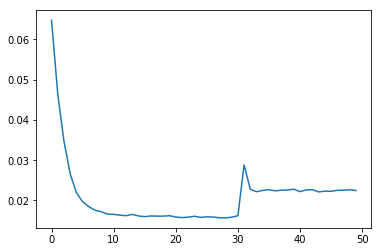

In [148]:
costsNPArray = np.array(costs)
epochXaxis = np.arange(len(costs))
plt.plot(epochXaxis, costsNPArray)
plt.show()

costsFilePath = '/home/muhammadayub/Desktop/CS230/models_saved/model2/model_12_7__epochsNum_'+str(num_epochs)+'.npy'
np.save(costsFilePath, costsNPArray )

# Restoring the Model - and Retraining from there
Kludge: Copied and pasted things into this module from module above -> should have a function like Sean's to retrieve or restore models and start retraining them

In [258]:
base_filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model2"
filepath =None # put in global namespace for ease of using later

costs = []
num_epochs = 500


###  Get the last cpkt file that was generated and load it in here , 
############
filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model2/model_12_7__"+str(49)+"_"+str(60)+".ckpt"

graph = tf.Graph()
with graph.as_default(): 
    with tf.Session(graph=graph) as sess:
        
        #define the graph
        X, Y = create_placeholders(64, 64, 26, 34)
        parameters = initialize_parameters()
        Z3 = forward_prop(X, parameters)
        #optimization 
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)

        #calculating the accuracy of the model 
        softmaxZ3 = tf.nn.softmax(Z3) # size will be 2200, 34
        output_class = tf.argmax(softmaxZ3,1) # size will be 2200, 1 or just (2200,)
        num_correct = tf.equal(output_class, tf.argmax(Y,1)) # must compare 2200
        num_correct_to_int = tf.cast(num_correct, tf.float32)
        accuracy = tf.reduce_mean(num_correct_to_int)
        
        
        saver = tf.train.Saver()

        saver.restore(sess , filepath)
        print("Model restored.")
        
        ########################################   Retrain starting here 
        
                #init must be after optimizer
        init = tf.global_variables_initializer()

        # Run the initialization
        sess.run(init)
        print('Starting ' , now())
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            np.random.shuffle(minibatches) # get new minibatch results 

            for i_ , minibatch in enumerate(minibatches[:80]):

                # Select a minibatch
                inputImage64 = generate_X_data_mini_batch(minibatch)   
                output_image64 = generate_Y_data_mini_batch(minibatch) 

                #run optimization
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: inputImage64, Y: output_image64})
                
                #compute cost
                minibatch_cost += temp_cost / MINIBATCHES_AMT

                #feel free to change this (just saves model every 20 iterations)
                if(i_ % 20 == 0 ):
                    #save model
                    filepath = base_filepath+"/model_12_7__"+str(epoch)+"_"+str(i_)+".ckpt"
                    print(temp_cost, " at file name: ", filepath[25:])
                    save_path = saver.save(sess, filepath)

            costs.append(minibatch_cost)
            print('Epoch End: ', datetime.now())
        
    

INFO:tensorflow:Restoring parameters from /home/muhammadayub/Desktop/CS230/models_saved/model1/model_12_7__0_0.ckpt
Model restored.


# Restore the Graph and Calculate the Test Set Accuracy / F1 Score
Can specify the dev set, test set, or training set

In [ ]:



######  Get the last cpkt file that was generated and load it in here 
###############
filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model2/model_12_7__"+str(49)+"_"+str(60)+".ckpt"

###  Filepath to write the evaluation metrics   -> make sure to change end of file to train/dev/test
###############
filepathEvalMetrics = "/home/muhammadayub/Desktop/CS230/models_saved/model2/model_12_7__"+str(49)+"_"+str(60)+"_evalMetrics_train.pickle"

###  Write in the batch you would like to get evaluation metrics on (minibatches, devMiniBatches, or testMiniBatches )
###############
minibatches_to_test_accuracy_of = copy.deepcopy(devMiniBatches)  # 'minibatches' or 'devMiniBatches' or 'testMiniBatches' for test error 


print(" Running ", len(minibatches_to_test_accuracy_of) , " minibatches to get the evaluation metrics")
#### Store global variables for the F1 , Precision and Recall Run 
accuracies= []
output_classes = []
predicted_classes = []
preds_one_hot_ev_value = None
output_one_hot_ev_value =None 


graph = tf.Graph()
with graph.as_default(): 
    with tf.Session(graph=graph) as sess:
        
        #define the graph
        X, Y = create_placeholders(64, 64, 26, 34)
        parameters = initialize_parameters()
        Z3 = forward_prop(X, parameters)
        #optimization 
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)

        #calculating the accuracy of the model 
        softmaxZ3 = tf.nn.softmax(Z3) # size will be 2200, 34
        output_class = tf.argmax(softmaxZ3,1) # size will be 2200, 1 or just (2200,)  # this is the predictions vector
        output_class_of_data =  tf.argmax(Y,1)
        num_correct = tf.equal(output_class, output_class_of_data) # must compare 2200
        num_correct_to_int = tf.cast(num_correct, tf.float32)
        accuracy = tf.reduce_mean(num_correct_to_int)
        
        
        saver = tf.train.Saver()
        saver.restore(sess , filepath)
        print("Model restored.")
        

        for i_ , minibatch in enumerate(minibatches_to_test_accuracy_of):
            inputImage64 = generate_X_data_mini_batch(minibatch)   
            output_image64 = generate_Y_data_mini_batch(minibatch) 
            
            #temp_cost = sess.run([cost], feed_dict={X: inputImage64, Y: output_image64})
            predicted_classes_val, output_class_val, accuracy_val = sess.run([output_class, output_class_of_data, accuracy], feed_dict={X: inputImage64, Y: output_image64})
            accuracies.append(accuracy_val)
            output_classes.append(output_class_val)
            predicted_classes.append(predicted_classes_val)
            
print("Done running on minibatches to get the accuracies, starting F1 calculations... ")
            
#new graph for concatenating things and getting into the right format for the F1 score 
graph = tf.Graph()
with graph.as_default(): 
    with tf.Session(graph=graph) as sess:            
    
        val1 = tf.concat(output_classes, axis = 0)
        
    
        #after running the minibatches-> we can concatenate the values 
        preds = tf.concat(predicted_classes,axis = 0)
        data_outputs = tf.concat(output_classes,axis = 0)
        
        preds_one_hot = tf.one_hot(preds, CATEGORIES_OF_OUTPUT)
        data_outputs_one_hot =tf.one_hot(data_outputs, d)#evaluated 
        preds_one_hot_ev, output_one_hot_ev = sess.run([preds_one_hot, data_outputs_one_hot])
        
        preds_one_hot_ev_value =preds_one_hot_ev
        output_one_hot_ev_value =output_one_hot_ev
        
#For Debugging below:
#         zVal = sess.run([Z3], feed_dict={X: inputImage64, Y: output_image64})
#         softMaxVal = sess.run([softmaxZ3], feed_dict={X: inputImage64, Y: output_image64})
#         output_class_val = sess.run([output_class], feed_dict={X: inputImage64, Y: output_image64})
#         num_correct_val = sess.run([num_correct], feed_dict={X: inputImage64, Y: output_image64})
#         num_correct_to_int_val = sess.run([num_correct_to_int], feed_dict={X: inputImage64, Y: output_image64})

In [141]:
_y_true_ = None
_y_pred_ = None 
_f1Score_ = None 
_precision_ = None 
_recall_ =None 
TPVal = None
FPVal = None
FNVal = None 
_f1_ = None 
#using the F1 function found online -> get the values for the predictions  
graph = tf.Graph()
with graph.as_default(): 
    y_true = tf.Variable(output_one_hot_ev_value)
    y_pred = tf.Variable(preds_one_hot_ev_value)
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    #moded from -> https://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix
    TP = tf.count_nonzero(y_pred * y_true, axis=0) 
    FP = tf.count_nonzero(y_pred * (y_true - 1), axis=0) 
    FN = tf.count_nonzero((y_pred - 1) * y_true, axis=0)  # .001 for numerical stability 

    #they are integers right now and should be floats for numerical stability 
    TP = tf.cast(TP, tf.float32)
    FP = tf.cast(FP, tf.float32)
    FN = tf.cast(FN, tf.float32)
    
    
    precision = TP / (TP + FP+tf.constant(.001))
    recall = TP / (TP + FN+tf.constant(.001))
    f1 = 2 * precision * recall / (precision + recall+tf.constant(.001))

    f1Score = tf.reduce_mean(f1)

    
    with tf.Session(graph=graph) as sess:    
        tf.global_variables_initializer().run(session=sess)
        _f1_, _y_true_, _y_pred_, _f1Score_ , _precision_ ,_recall_ , TPVal,FPVal, FNVal = sess.run([f1, y_true, y_pred, f1Score, precision ,recall, TP,FP, FN ])          


In [130]:
accuracyArray = np.array(['Accuracy', sum(np.array(accuracies).flatten())/len(accuracies)*100 , 
                          '_y_true_' , str(_y_true_),
                            '_y_pred_' ,str(_y_pred_) ,
                            '_f1Score_' ,str(_f1Score_) ,
                            '_precision_' ,str(_precision_) ,
                            '_recall_' ,str(_recall_) ,
                            'TPVal' ,str(TPVal),
                            'FPVal' , str(FPVal),
                            'FNVal' , str(FNVal)
                          ])

metricDictionary = {'_y_true_' = _y_true_,
'_y_pred_' = _y_pred_ ,
'_f1Score_' = _f1Score_ ,
'_precision_' = _precision_ ,
'_recall_' =_recall_ ,
'TPVal' = TPVal,
'FPVal' = FPVal,
'FNVal' = FNVal ,
'_f1_' = _f1_ }

# we are only interested in the F1 score at the Macro level
print('F1 score (multiclass): ' , mac)        
print('Accuracy', sum(np.array(accuracies).flatten())/len(accuracies)*100)

F1 score (multiclass):  nan
Accuracy 95.45813234228837


In [ ]:
#write the values out to the numpy file 
print(accuracyArray)
np.save(filepathEvalMetrics[:-6]+"npy",accuracyArray)

pObj_old(metricDictionary, filepathEvalMetrics)

# Old code (don't delete until we have a success run without bugs)

In [17]:
# datesb -- no need 
# dates -- no need
# buildings  buildingsT -> buildingsTStacked
# businesses    businessesT -> businessesTStacked
# socio   socioT -> socioTStacked
# lentries 
# waterway  -- not part of data 
# outputsData 


#next steps -> add lentries, temperature, and masks 

# now we write a function that will return to us the correct minibatch , with all the image data generated
def generateMinibatch(minibatchIndices):    #everything must be transposed
    #general steps:
    #get the x inputs
    #    same as the file of text 
    
    #step 1. dates (make 12 layers of month, day, year , timeOfDay)  # dateLayers don't need to be transposed -> just 1 value
    dateLayers = generateDatesLayers(minibatchIndices, datesb) # (150, 256, 256, 4)  => len(minibatchIndices) = 150
    
    #step 2. Buildings 10 layers 
    buildingLayers = stackManyTimes(buildingsT, len(minibatchIndices))  # buildingsT should be (256,256,10) and result should (150, 256, 256, 10)
  
    #step 3. 
    businessesLayers = stackManyTimes(businessesT, len(minibatchIndices))
    
    #step 4. L entries
    #come back to this one   => must be transposed!!!
    LentryLayers = None
    
    #step 5. socio
    socioLayers = stackManyTimes(socioT, len(minibatchIndices))
    
    #step 6. temperature #should be format of
    #pass on this for now -> will add this for later iterations
    
    #step 7. concat everything
    inputImage = np.concatenate((dateLayers,buildingLayers,businessesLayers,socioLayers) , axis = -1)
#     print(np.where((inputImage[:4]==dateLayers)==False))
#     print(np.where((inputImage[4:14]==buildingLayers)==False))

    #step 7. outputs
    output_image = outputsDataReal[minibatchIndices]  # calculateOutput(minibatchIndices)
    return inputImage, output_image#, waterway

def generateDatesLayers(minibatchIndices, datesb):
    base_img_mask = np.ones((256, 256), dtype=np.float32)
    xy = np.dstack([base_img_mask]*4) # shape (256, 256, 4)
    dateLayers = datesb[minibatchIndices] # (len(minibatchIndices) , 4)
    dateLayersReshaped = dateLayers.reshape((len(dateLayers), 1,1,dateLayers.shape[1])) # (len(minibatchIndices),1,1 , 4)
    xyz = xy* dateLayersReshaped 
    return xyz

def transpose3dImage(img):
    img_T = img.T #tested this actually does what we wante it to do.  
    return img_T


def stackManyTimes(_3dimg,times):
    _3dimg_shape = _3dimg.shape
    result = np.zeros(shape=(times, _3dimg_shape[0], _3dimg_shape[1],_3dimg_shape[2] ), dtype=np.float32)
    for x in range(times):
        result[x] = _3dimg
    return result

def calculateOutput(sample):
    batchMin = min(sample)#67050
    batchMax = max(sample)#67199
    #     batchMax  = 69050
    #print("batch min " , batchMin," batch max ", batchMax )
    remMin = batchMin % BATCHSIZE_Y
    multipleMin = int(batchMin / BATCHSIZE_Y)

    remMax = batchMax % BATCHSIZE_Y
    multipleMax = int(batchMax / BATCHSIZE_Y)
    
    batch = None
    if(multipleMin != multipleMax):# have to concatenate  batch size can never be more than 3000#
        print('here')
        batch = np.concatenate((outputsData[multipleMin],outputsData[multipleMax]), axis = 0)
    else:
        print('not here')
        batch = outputsData[multipleMin]

    offset = multipleMin*BATCHSIZE_Y
    sample_ = np.array(sample)-offset
    data_output = batch[sample_]
    return data_output

def splitWaterWay(waterwayImg):
    imagesList = np.split(waterwayImg, 4, axis = 0)
    images64by64 = []

    for almostImage in imagesList:
        imagesList64by64 = np.split(almostImage, 4, axis = 1) # axis is 0, 1, 2
        for actual64by64 in imagesList64by64:
            images64by64.append(actual64by64)
    #     for i,_64 in enumerate(images64by64):
    #         print(i, _64.shape)
    return np.concatenate(images64by64, axis = 0)

def split256by256StackOnAxis(inputImg):  #returns the images in (64 , 64, numberOfChannels)
    imagesList = np.split(inputImg, 4, axis = 1)
    images64by64 = []

    for almostImage in imagesList:
        imagesList64by64 = np.split(almostImage, 4, axis = 2) # axis is 0, 1, 2
        for actual64by64 in imagesList64by64:
            images64by64.append(actual64by64)
    #     for i,_64 in enumerate(images64by64):
    #         print(i, _64.shape)
    return np.concatenate(images64by64, axis = 0)

def getOutputYVector(y_output_image64, numCats): # y_output_image64 is of shape (3200,64,64)  , 34 categories + -1
    result = np.zeros((len(y_output_image64), numCats), dtype=np.float32)
    cCount = None 
    for i_, img in enumerate(y_output_image64):
        cCount = Counter(img.flatten())
        if(len(np.unique(img)) == 1): #if all -1's
            result[i_][0] = 1
        else: # get the second most common thing (since -1 are going to be the most common)
            result[i_][int(cCount.most_common()[1][0])+1] = 1 # get the second value (index of 1) of most common array
    return result

    #get the argmax for now  -1 goes to 0, 0 goes to 1, etc. until you have 33 going to 34   -> kludge need to set this to -1
    #result[i_][int(cCount.most_common()[0][0])+1] = 1

def transformTo64(inputImage, output_image, numCats):
    inputImage64 =  split256by256StackOnAxis(inputImage)
    output_image64 = split256by256StackOnAxis(output_image)
    output_image64 = getOutputYVector(output_image64, numCats) #34 categories since we use -1s, but then shave them off
    return inputImage64, output_image64

def generateWaterWayMask(waterway, threshold):# between 0 and 4096, need atmost 200 to be water 
    sizeOfOneMiniBatch = int(len(indices_)/MINIBATCHES_AMT)
    waterwayMask = np.zeros((sizeOfOneMiniBatch, 256,256), dtype=np.float32)
    for i_ in range(len(waterwayMask)):
        waterwayMask[i_] = waterway
        
    #now that we have the ( 200, 256,256)  (sizeOfOneMiniBatch is 200 for example)
    #we can break it up into the 64 by 64 images
    waterwayMask64 = split256by256StackOnAxis(waterwayMask)
    #from here, you count up each one of the 64 by 64 images and set to the threshold
    waterwayMaskIndices = [] # include if they are one 
    for i_ in range(len(waterwayMask64)):
        if(np.sum(waterwayMask64[i_]) <= threshold): #> would mean you have more 1's than allowed -> not tolerable 
            waterwayMaskIndices.append(i_)
    return waterwayMaskIndices

In [80]:
### This function was not done by Ali or Sean: 
# it was found at the link https://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix
# it calculates multi - label class F1 score and True positives, True Negs, etc.
# very useful function we modified it for our own needs 
# though since we are using a regular macro F1 score 

def tf_f1_score(y_true, y_pred):
    """Computes 3 different f1 scores, micro macro
    weighted.
    micro: f1 score accross the classes, as 1
    macro: mean of f1 scores per class
    weighted: weighted average of f1 scores per class,
            weighted from the support of each class


    Args:
        y_true (Tensor): labels, with shape (batch, num_classes)
        y_pred (Tensor): model's predictions, same shape as y_true

    Returns:
        tuple(Tensor): (micro, macro, weighted)
                    tuple of the computed f1 scores
    """

    f1s = [0, 0, 0]

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    for i, axis in enumerate([None, 0]):
        TP = tf.count_nonzero(y_pred * y_true, axis=axis)
        FP = tf.count_nonzero(y_pred * (y_true - 1), axis=axis)
        FN = tf.count_nonzero((y_pred - 1) * y_true, axis=axis)

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)

        f1s[i] = tf.reduce_mean(f1)

    weights = tf.reduce_sum(y_true, axis=0)
    weights /= tf.reduce_sum(weights)

    f1s[2] = tf.reduce_sum(f1 * weights)

    micro, macro, weighted = f1s
    return micro, macro, weighted

# tf.reset_default_graph()
# y_true = tf.Variable(labels)
# y_pred = tf.Variable(predictions)
# micro, macro, weighted = tf_f1_score(y_true, y_pred)
# with tf.Session() as sess:
#     tf.global_variables_initializer().run(session=sess)
#     mic, mac, wei = sess.run([micro, macro, weighted])
#     print(mic)
#     print(mac)
#     print(wei)